<a href="https://colab.research.google.com/github/masthan07/fraud_detection_project/blob/main/fraud_detection_using_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle


Step 1: Load and Basic Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Load data
train_trans = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# Merge
df = train_trans.merge(train_identity, on='TransactionID', how='left')

# Remove high missing value columns
threshold = 0.7
missing_pct = df.isnull().sum() / len(df)
cols_to_drop = missing_pct[missing_pct > threshold].index
df = df.drop(columns=cols_to_drop)

print(f"Shape after dropping sparse columns: {df.shape}")

Shape after dropping sparse columns: (2845, 223)


Step 2: Feature Preparation


In [ ]:
# Separate features and target
X = df.drop(['TransactionID', 'isFraud', 'TransactionDT'], axis=1)
y = df['isFraud']

# Label encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Fill NaN with -999 (XGBoost can handle it, but explicit is clearer)
X = X.fillna(-999)

print(f"Final features: {X.shape[1]}")
print(f"Fraud cases: {y.sum()} ({y.mean()*100:.2f}%)")

Final features: 220
Fraud cases: 57 (2.00%)


Step 3: Train-Test Split (NO BALANCING)

In [ ]:
# Simple stratified split - keep original imbalanced distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set: {len(X_train)}")
print(f"Test set: {len(X_test)}")
print(f"Training fraud ratio: {y_train.mean()*100:.2f}%")# Simple stratified split - keep original imbalanced distribution



Training set: 2276
Test set: 569
Training fraud ratio: 2.02%


Step 4: Calculate scale_pos_weight

In [ ]:
# This is the KEY parameter for handling imbalance
# Formula: (number of negative samples) / (number of positive samples)

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"\nClass distribution:")
print(f"Negative (legitimate): {n_negative}")
print(f"Positive (fraud): {n_positive}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")


Class distribution:
Negative (legitimate): 2230
Positive (fraud): 46
scale_pos_weight: 48.48


Step 5: Train XGBoost with scale_pos_weight

In [ ]:
# Basic model with scale_pos_weight handling imbalance
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # THIS handles imbalance
    random_state=42,
    tree_method='hist',
    eval_metric='auc',
    use_label_encoder=False
)

# Train on IMBALANCED data (no SMOTE needed!)
print("\nTraining model...")
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n=== XGBoost with scale_pos_weight Results ===")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")


Training model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:51:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost with scale_pos_weight Results ===
              precision    recall  f1-score   support

  Legitimate       0.99      1.00      0.99       558
       Fraud       0.71      0.45      0.56        11

    accuracy                           0.99       569
   macro avg       0.85      0.73      0.77       569
weighted avg       0.98      0.99      0.98       569


AUC-ROC: 0.8614
F1-Score: 0.5556


Step 6: Early Stopping for Better Performance

In [ ]:
# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# Model with early stopping
xgb_early = xgb.XGBClassifier(
    n_estimators=1000,  # Set high, early stopping determines actual
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    eval_metric='auc',
    use_label_encoder=False
)

print("\nTraining with early stopping...")
xgb_early.fit(
    X_train_split, y_train_split,
    # eval_set=[(X_val, y_val)], # Removed as early stopping is not supported
    # early_stopping_rounds=50, # Removed as early stopping is not supported
    # verbose=20 # Removed as early stopping is not supported
)

# Evaluate
y_pred_early = xgb_early.predict(X_test)
y_pred_proba_early = xgb_early.predict_proba(X_test)[:, 1]

print("\n=== Results with Early Stopping ===")
# print(f"Best iteration: {xgb_early.best_iteration}") # Removed as best_iteration is not available
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_early):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_early):.4f}")


Training with early stopping...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:51:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Results with Early Stopping ===
AUC-ROC: 0.8043
F1-Score: 0.3158


Step 7: Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 500],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

xgb_tuning = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Keep this fixed
    random_state=42,
    tree_method='hist',
    eval_metric='auc',
    use_label_encoder=False
)

random_search = RandomizedSearchCV(
    xgb_tuning,
    param_distributions=param_grid,
    n_iter=15,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\nTuning hyperparameters...")
random_search.fit(X_train, y_train)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best CV F1-score: {random_search.best_score_:.4f}")

# Best model
best_model = random_search.best_estimator_


Tuning hyperparameters...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:52:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best CV F1-score: 0.4234


Step 8: Final Evaluation


=== Final Optimized Results ===
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99       558
       Fraud       0.50      0.27      0.35        11

    accuracy                           0.98       569
   macro avg       0.74      0.63      0.67       569
weighted avg       0.98      0.98      0.98       569


AUC-ROC: 0.8615
F1-Score: 0.3529


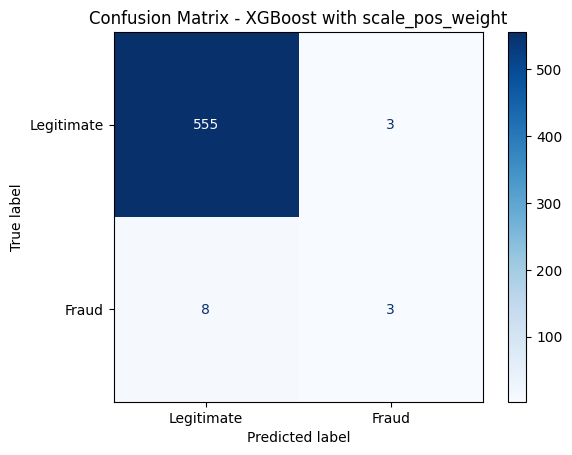

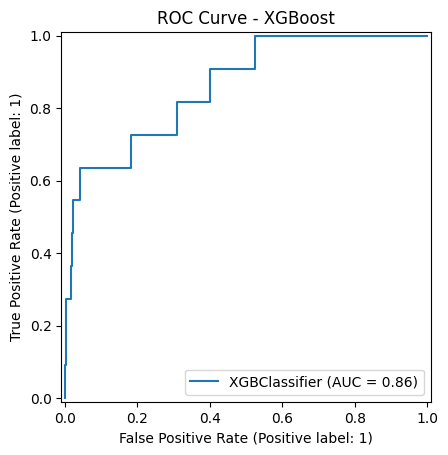

In [ ]:
# Use best model for final predictions
y_pred_final = best_model.predict(X_test)
y_pred_proba_final = best_model.predict_proba(X_test)[:, 1]

print("\n=== Final Optimized Results ===")
print(classification_report(y_test, y_pred_final, target_names=['Legitimate', 'Fraud']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost with scale_pos_weight')
plt.show()

# ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve - XGBoost')
plt.show()

Step 9: Feature Importance


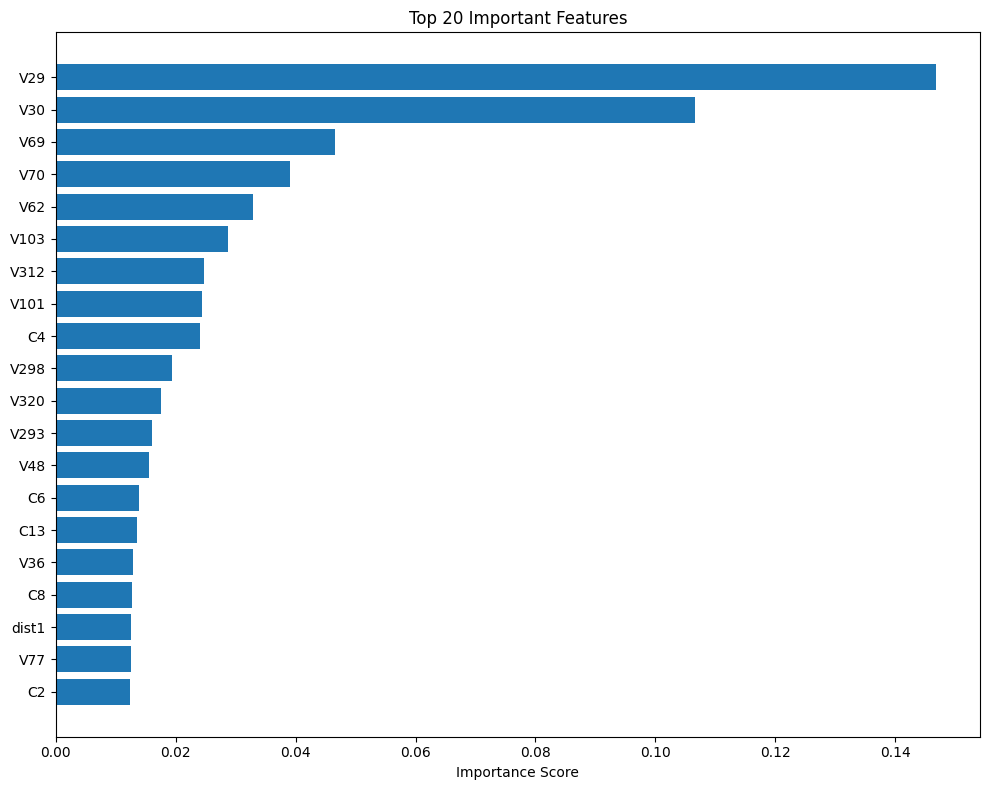


Top 10 Features:
    feature  importance
68      V29    0.146780
69      V30    0.106575
108     V69    0.046610
109     V70    0.039069
101     V62    0.032814
142    V103    0.028761
210    V312    0.024709
140    V101    0.024461
15       C4    0.024057
196    V298    0.019454


In [ ]:
# Top features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
plt.barh(top_20['feature'], top_20['importance'])
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10))

Step 10: Save Model

In [ ]:
import pickle

# Save trained model
with open('xgb_fraud_detector.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved as 'xgb_fraud_detector.pkl'")

Model saved as 'xgb_fraud_detector.pkl'


In [ ]:
from google.colab import files

files.download('xgb_fraud_detector.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>